# **CONTEXT**

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

It's a great dataset for evaluating simple regression models.

In [128]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

from folium import plugins

In [129]:
df1 = pd.read_csv('./bengaluru_house_prices.csv')

In [130]:
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [131]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [132]:
df1.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


drop features not required to build our model

In [133]:
df1.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns', inplace=True)

Data Cleaning: Handle NA Values

In [134]:
df1.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [135]:
df1 = df1.dropna()
df1.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

Feature Engineering
- Add new feature (integer) for bhk (Bedrooms Hall Kitchen)

In [136]:
df1['bhk'] = df1['size'].apply(lambda x: int(x.split(' ')[0]))
df1.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [137]:
df1.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [138]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [139]:
df1[~df1['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


if there's a range like 2100-2850 we just take the average

In [140]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [141]:
df1.total_sqft = df1.total_sqft.apply(convert_sqft_to_num)
df1 = df1[df1.total_sqft.notnull()]
df1.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


Feature Engineering
- add a new feature called price per square feet

In [142]:
df1['price_per_sqft'] = df1['price'] * 100000/df1['total_sqft']
df1.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


Apply dimensionality reduction technique to reduce number of locations

In [143]:
location_stats = df1['location'].value_counts(ascending=False)
location_stats

Whitefield                   532
Sarjapur  Road               392
Electronic City              302
Kanakpura Road               264
Thanisandra                  232
                            ... 
Indiranagar HAL 2nd Stage      1
Maruthi HBCS Layout            1
K R C kothanur                 1
1Channasandra                  1
Abshot Layout                  1
Name: location, Length: 1298, dtype: int64

In [144]:
location_stats.values.sum()

13200

dimensionality reduction
- any location having less than 10 data points should be tagged as 'other' location

In [145]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Ganga Nagar                  10
Nagappa Reddy Layout         10
Naganathapura                10
Sadashiva Nagar              10
Basapura                     10
                             ..
Indiranagar HAL 2nd Stage     1
Maruthi HBCS Layout           1
K R C kothanur                1
1Channasandra                 1
Abshot Layout                 1
Name: location, Length: 1058, dtype: int64

In [146]:
len(df1.location.unique())

1298

In [147]:
df1.location = df1.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df1.location.unique())

241

Outlier removal using business logic
- normally square ft per bedroom is 300. For instance, if you have 400 sqft apartment with 2 bhk that seems suspicious and should be removed as an outlier

In [148]:
df1[df1.total_sqft/df1.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,other,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [149]:
df1 = df1[~(df1.total_sqft/df1.bhk<300)]

Outlier removal using standard deviation and mean

In [150]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df], ignore_index=True)
    return df_out
df1 = remove_pps_outliers(df1)
df1.shape

(10245, 7)

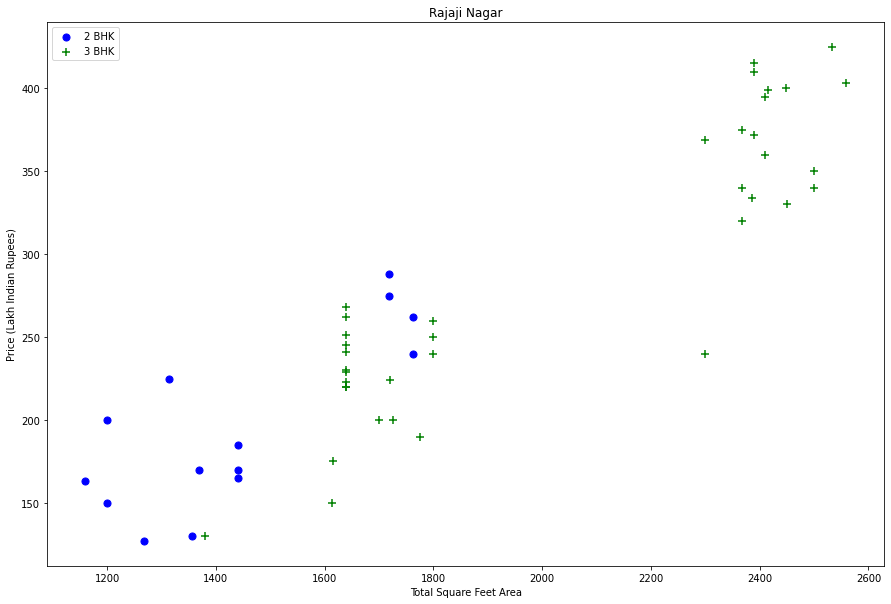

In [151]:
import matplotlib
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df1,"Rajaji Nagar")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [152]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df1 = remove_bhk_outliers(df1)
df1.shape

(7331, 7)

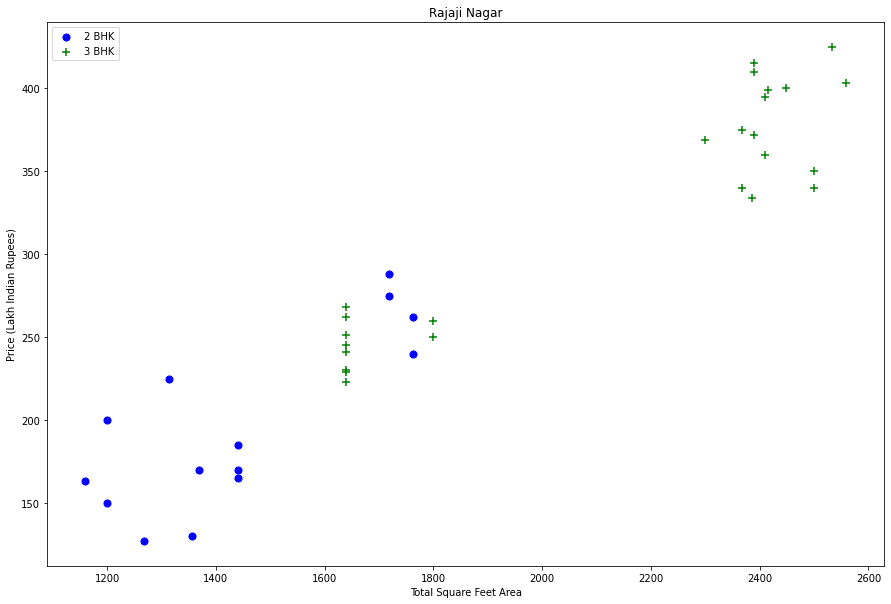

In [153]:
plot_scatter_chart(df1,"Rajaji Nagar")

Text(0, 0.5, 'Count')

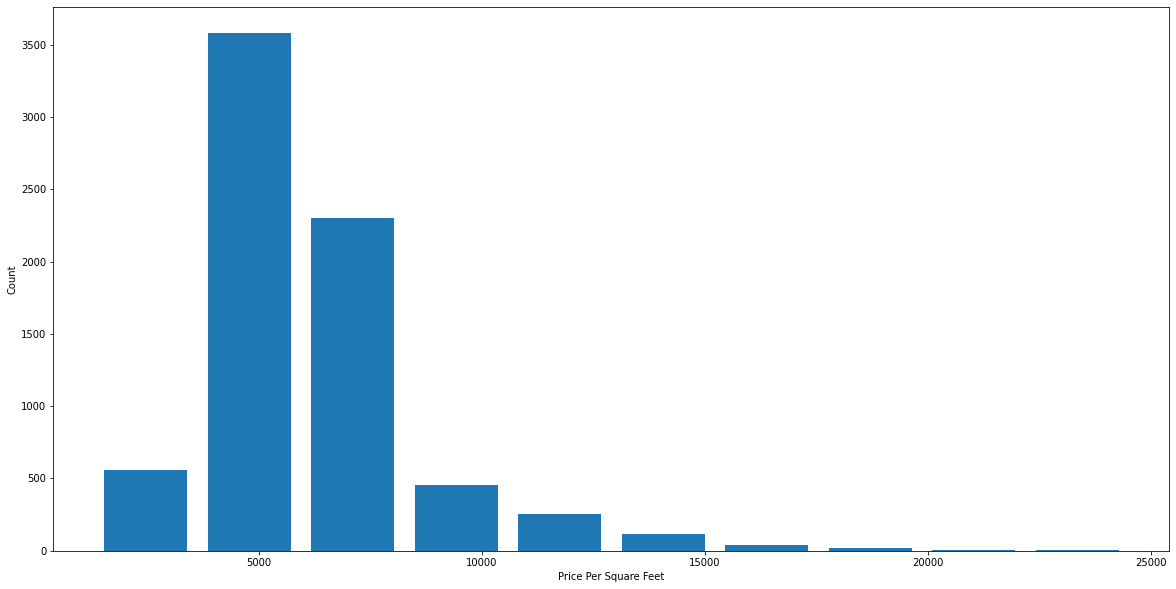

In [154]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df1.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Outlier removal using bathrooms feature

Text(0, 0.5, 'Count')

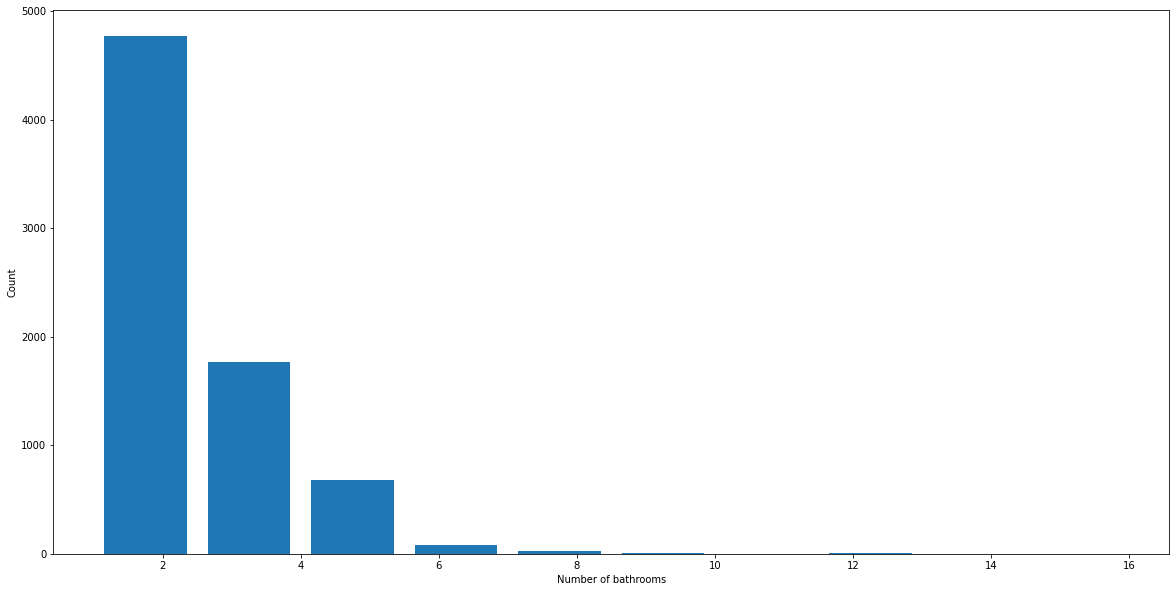

In [155]:
plt.hist(df1.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [156]:
df1[df1.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5271,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8478,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8567,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9307,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [157]:
df1[df1.bath>df1.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1637,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5232,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6702,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8402,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [158]:
df1 = df1[df1.bath<df1.bhk+2]
df1.shape

(7253, 7)

In [159]:
df1.drop(['size','price_per_sqft'],axis='columns', inplace=True)
df1.head(3)

,location,total_sqft,bath,price,bhk
1,Devarachikkanahalli,1250.0,2.0,40.0,2
2,Devarachikkanahalli,1200.0,2.0,83.0,2
3,Devarachikkanahalli,1170.0,2.0,40.0,2


Use One hot encoding for location

In [160]:
dummies = pd.get_dummies(df1.location)
dummies.head(3)

,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
df1 = pd.concat([df1,dummies.drop('other',axis='columns')],axis='columns')
df1.head()

,location,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,Devarachikkanahalli,1250.0,2.0,40.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Devarachikkanahalli,1200.0,2.0,83.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Devarachikkanahalli,1170.0,2.0,40.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Devarachikkanahalli,1425.0,2.0,65.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Devarachikkanahalli,947.0,2.0,43.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
df1 = df1.drop('location',axis='columns')
df1.head(2)

,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,83.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Bit more analysis for fun!

In [163]:
g1 = [go.Box(y=df1.bhk,name="Bedrooms",marker=dict(color="rgba(51,0,0,0.9)"),hoverinfo="name+y")]
g2 = [go.Box(y=df1.bath,name="Bathrooms",marker=dict(color="rgba(0,102,102,0.9)"),hoverinfo="name+y")]
layout2 = go.Layout(title="Bedrooms and Bathrooms",yaxis=dict(range=[0,13])) 
fig2 = go.Figure(data=g1+g2,layout=layout2)
iplot(fig2)

(0.0, 4001.8)

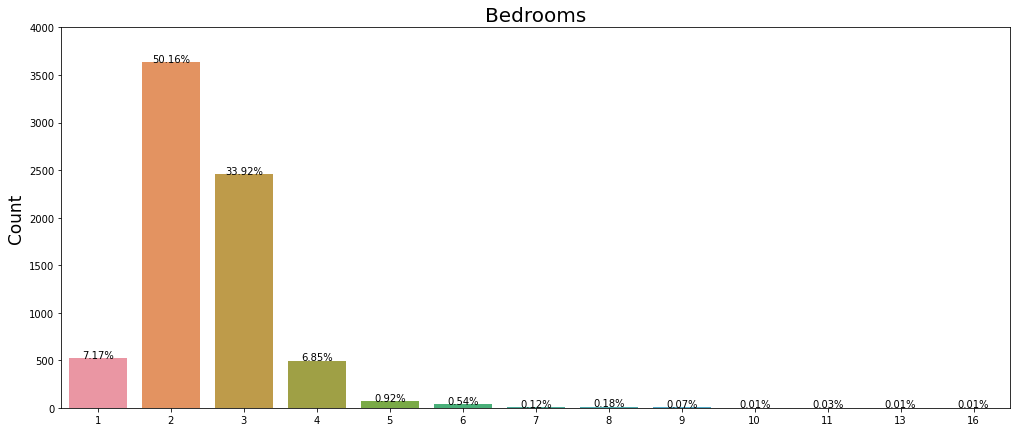

In [164]:
total = len(df1)
ax1 = plt.figure(figsize=(17,7))

g = sns.countplot(x='bhk', data=df1)
g.set_title("Bedrooms", fontsize=20)
g.set_xlabel("", fontsize=17)
g.set_ylabel("Count", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 
g.set_ylim(0, max(sizes) * 1.1)

<AxesSubplot:xlabel='total_sqft', ylabel='price'>

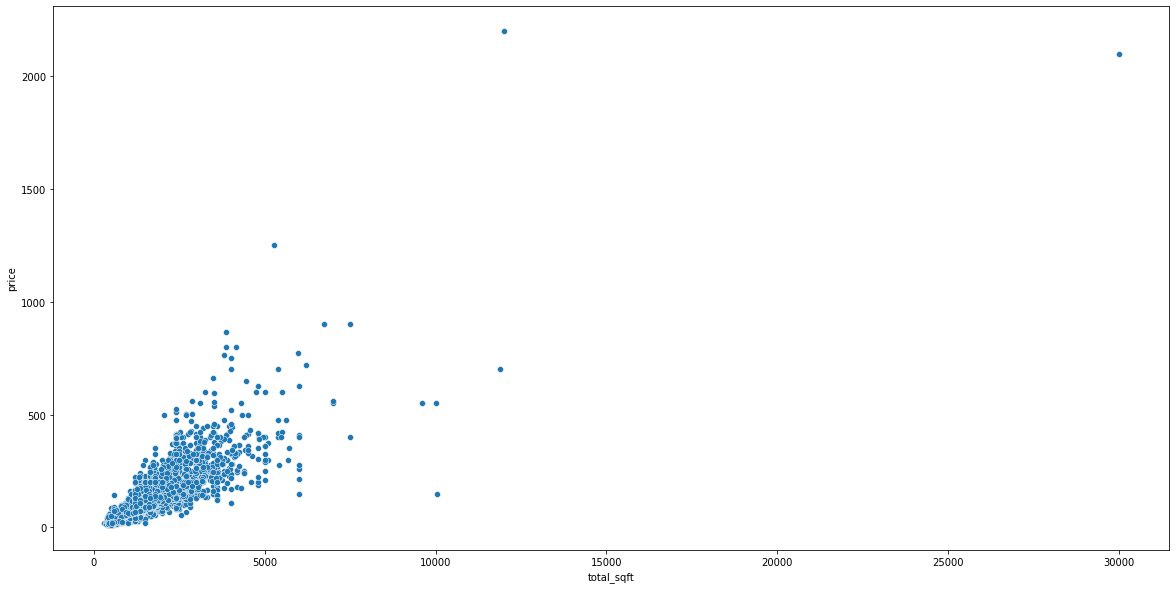

In [165]:
sns.scatterplot(x = 'total_sqft', y = 'price', data = df1)

next dataset we play with before returning to df1 is downloaded from : https://www.kaggle.com/harlfoxem/housesalesprediction

In [166]:
df2 = pd.read_csv('./kc_house_data.csv')

<AxesSubplot:>

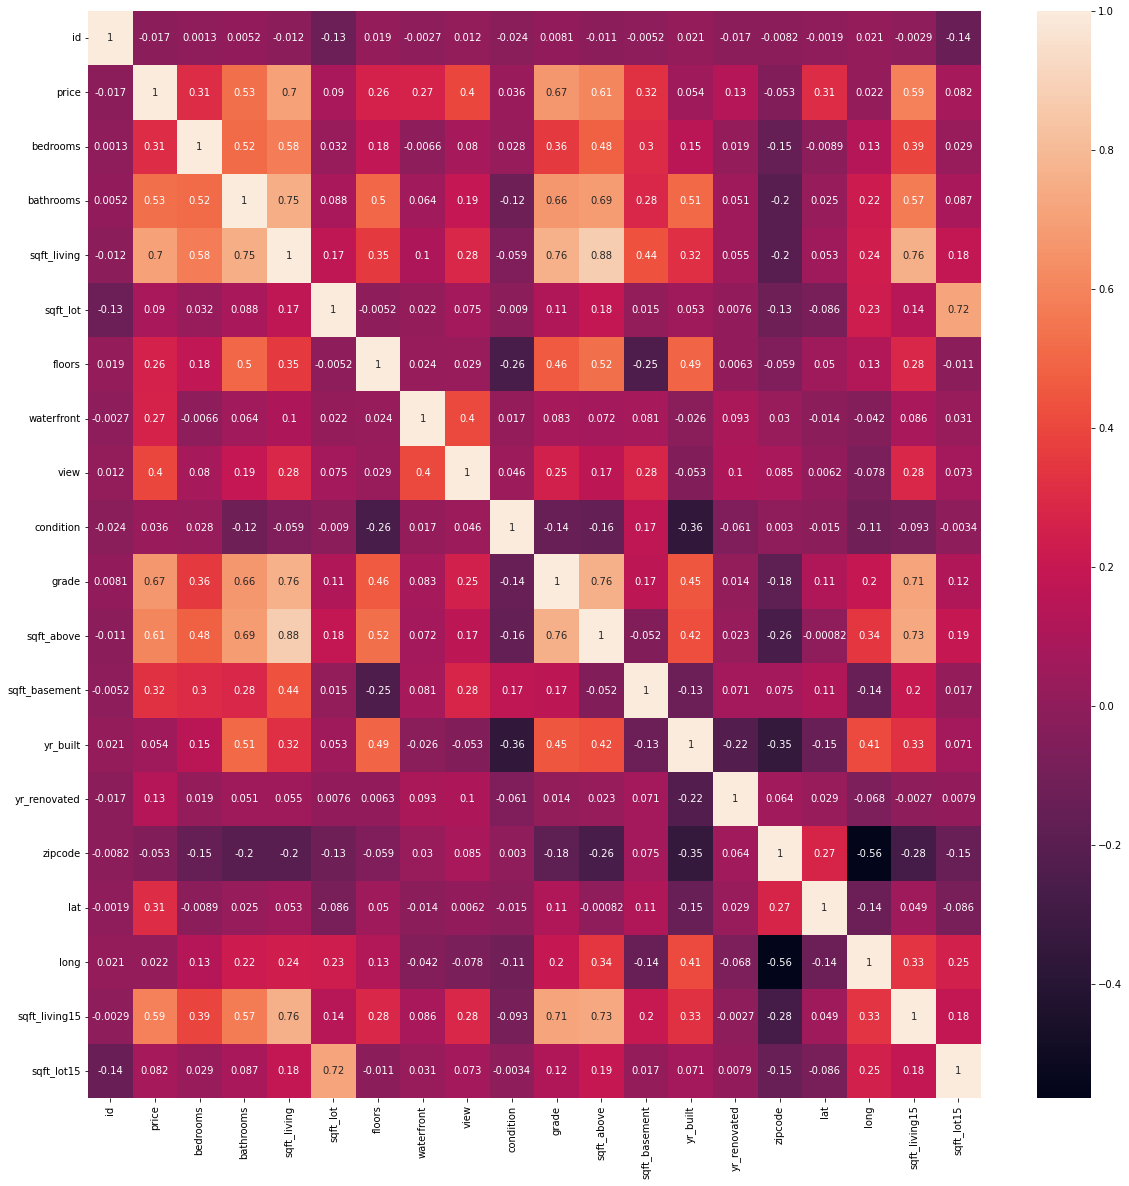

In [167]:
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(df2.corr(), annot = True)

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_above'}>],
       [<AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'zipcode'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'cen

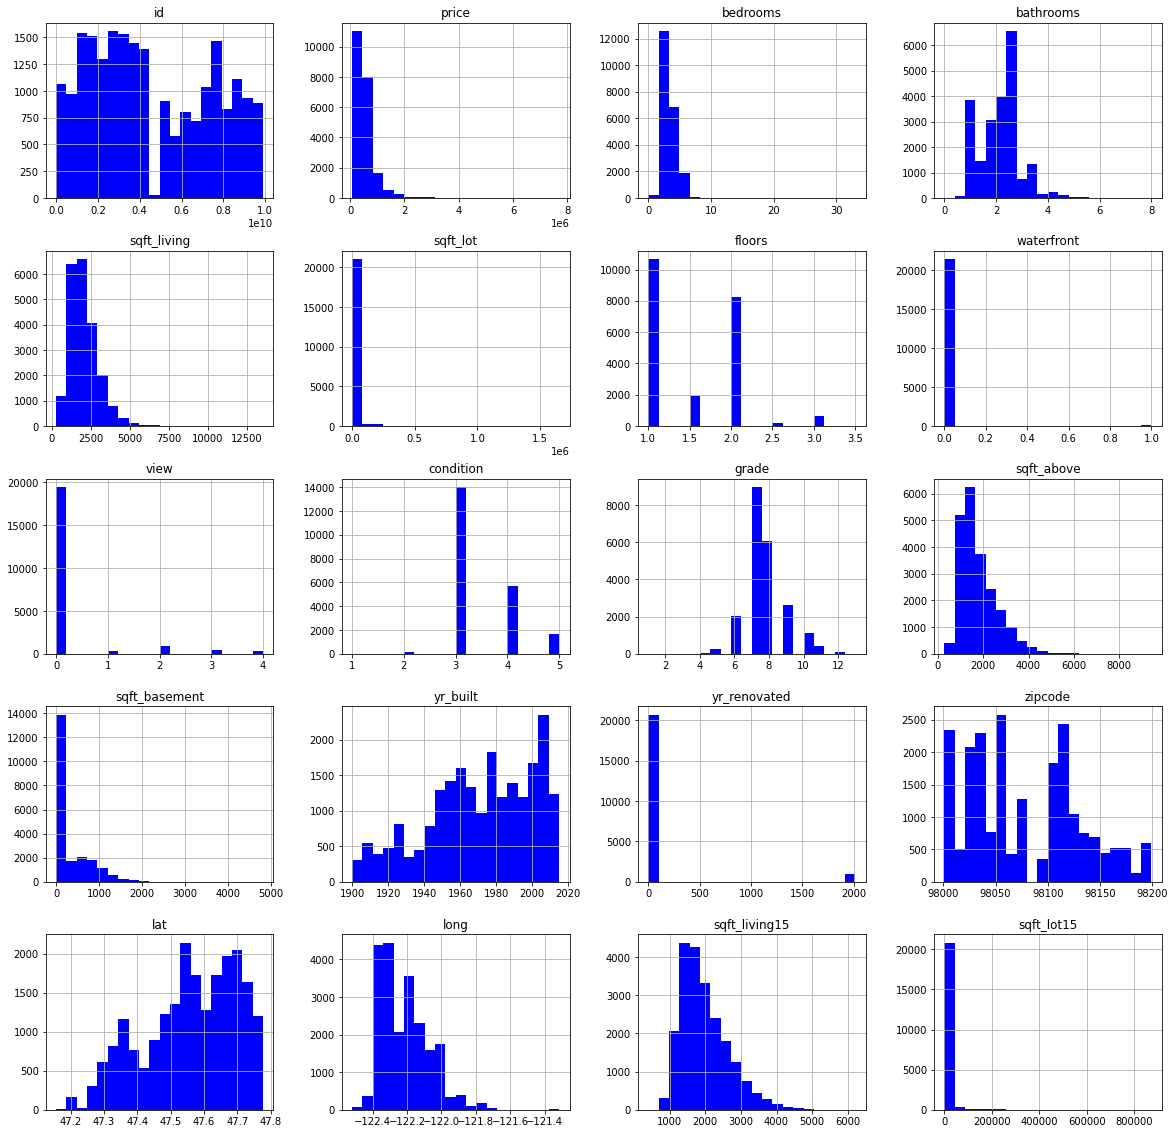

In [168]:
df2.hist(bins = 20, figsize = (20,20), color = 'b')

In [169]:

df2["color"] = ""
df2.color[df2.grade == 1] = "rgb(255,255,255)"
df2.color[df2.grade == 2] = "rgb(220,220,220)"
df2.color[df2.grade == 3] = "rgb(242, 177, 172)"
df2.color[df2.grade == 4] = "rgb(255,133,27)"
df2.color[df2.grade == 5] = "rgb(255,255,204)"
df2.color[df2.grade == 6] = "rgb(255,65,54)"
df2.color[df2.grade == 7] = "rgb(178,37,188)"
df2.color[df2.grade == 8] = "rgb(51,51,0)"
df2.color[df2.grade == 9] = "rgb(37,188,127)"
df2.color[df2.grade == 10] = "rgb(26,51,176)"
df2.color[df2.grade == 11] = "rgb(132,10,10)"
df2.color[df2.grade == 12] = "rgb(82,80,80)"
df2.color[df2.grade == 13] = "rgb(0,0,0)"

dataplus = df2[np.logical_and(df2.grade >= 7,df2.yr_built >= 2000)] 
lats = list(dataplus.lat.values)
longs = list(dataplus.long.values)

mapbox_access_token = 'pk.eyJ1IjoiZGFya2NvcmUiLCJhIjoiY2pscGFheHA1MXdqdjNwbmR3c290MTZ6dCJ9.K1FMv_q3ZVlKP13RrjFkjg'
mapp = [go.Scattermapbox(lat=lats,lon=longs,mode="markers",marker=dict(size=4,color=dataplus["color"]) ,hoverinfo="text",text="Grade:"+dataplus.grade.apply(str)+" Built Year:"+dataplus.yr_built.apply(str)+" Price:"+dataplus.price.apply(str))]
layout5 = dict(title="Grade(+7) - Built Year(+2000) Map",width=800,height=750,hovermode="closest",mapbox=dict(bearing=0,pitch=0,zoom=9,center=dict(lat=47.5,lon=-122.161),accesstoken=mapbox_access_token))
fig5 = go.Figure(data=mapp,layout=layout5)
iplot(fig5)

/var/folders/fc/9dptd99s0h5f47szq92yhync0000gn/T/ipykernel_16901/100081948.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fc/9dptd99s0h5f47szq92yhync0000gn/T/ipykernel_16901/100081948.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fc/9dptd99s0h5f47szq92yhync0000gn/T/ipykernel_16901/100081948.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fc/9dptd99s0h5f47szq92yhync0000gn/T/ipykernel

Time to build the model

In [170]:
X = df1.drop(['price'], axis='columns')


In [171]:
y = df1.price

In [172]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [173]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.778086605109314

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [174]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.84014922, 0.78873287, 0.86373278, 0.86871995, 0.88094502])

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [175]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavi

,model,best_score,best_params
0,linear_regression,0.848456,{'normalize': False}
1,lasso,0.709009,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.757032,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


Linear regression gives best score

In [176]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]
    print(loc_index)

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [177]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



89.11865847973199

In [178]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [179]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))